In [1]:

import gene_model

import math
from typing import List, Union
import msprime
import tskit
import numpy as np

# Given: rho, theta, hgt_rate, core_tree

def simulator (
    theta: int,
    rho: float,
    hgt_rate: float = 0,
    core_tree: Union[str, None] = None,
    num_samples: Union[int, None] = None,
    infinite_sites_factor: int = 3,
) -> tskit.TreeSequence:

    if core_tree is not None and num_samples is not None:
        raise ValueError(
            "A core tree and parameters for simulation were provided. Choose either."
        )
        
    if core_tree is None and num_samples is None:
        raise ValueError(
            "Neither a core tree or parameters for simulation were provided. Choose either."
        )
    
    if core_tree is None:
        core_tree = msprime.sim_ancestry(
                samples=num_samples,
                sequence_length=1,
                ploidy=1,
                recombination_rate=0,
                gene_conversion_rate=0,
                gene_conversion_tract_length=1,  # One gene
            )
    
    ce_from_nwk = core_tree.first().newick()
    
    # Calculate the number of genes in the root of the core tree:
    
    expected_number_of_genes_in_core_root = 1
    for k in range(1, 100):
        term = (hgt_rate ** k) / math.prod(1 + rho + i for i in range(k))
        expected_number_of_genes_in_core_root += term
    expected_number_of_genes_in_core_root = expected_number_of_genes_in_core_root * theta / rho
    print(expected_number_of_genes_in_core_root)
    
    number_of_genes_in_core_root = np.random.poisson(lam=expected_number_of_genes_in_core_root)
    
    if number_of_genes_in_core_root > 0:
        mts_core_root = gene_model.gene_model(
            theta=0,
            rho=rho,
            gene_conversion_rate=0,
            recombination_rate=0,
            hgt_rate=hgt_rate,
            num_samples=num_samples,
            num_sites=number_of_genes_in_core_root,
            double_site_relocation=False,
            core_genes=True,
        )
    
    #  Calculate the tree and the number of genes which were observed:
    
    num_sites = round(infinite_sites_factor * expected_number_of_genes_in_core_root)
    
    mts = gene_model.gene_model(
        theta=theta,
        rho=rho,
        gene_conversion_rate=0,
        recombination_rate=0,
        hgt_rate=hgt_rate,
        num_samples=num_samples,
        num_sites=num_sites,
        double_site_relocation=False,
        core_genes=False,
    )
    
    # Calculate the lenghts of the tree at each site:
    
    tree_lengths = np.array([mts.at(i).total_branch_length for i in range(0,num_sites)])
    tree_lengths_average = sum(tree_lengths)/len(tree_lengths)
    
    # Calculate the number of gene gains:
    number_of_gains = np.random.poisson(lam=tree_lengths_average*theta)
    
    while (number_of_gains > num_sites):
        number_of_gains = np.random.poisson(lam=tree_lengths_average*theta)
    
    # Make sure all lengths are positive
    if np.any(tree_lengths <= 0):
        raise ValueError("Tree with length 0 found.")
    
    # Choose number_of_gains sites:
    
    selected_trees_indexes = []
    k = 0 # This index describes how often a site has gained multiple mutations
    
    print(number_of_gains)
    while (len(selected_trees_indexes) < number_of_gains):
    
        if k == 0:
            probabilities = tree_lengths / sum(tree_lengths)
        else: 
            probabilities = np.ones(num_sites)
            for i in range(0,k+1):
                probabilities = probabilities - math.comb(number_of_gains, i) * (1-tree_lengths / sum(tree_lengths)) ** (number_of_gains-i) * (tree_lengths / sum(tree_lengths)) ** i
            probabilities[selected_trees_indexes] = 0
            probabilities = probabilities / sum(probabilities)
    
        selected_trees = np.random.choice(np.array(range(0, num_sites)), size=number_of_gains - len(selected_trees_indexes), replace=True, p=probabilities)
        selected_trees_indexes.extend(np.unique(selected_trees))
        k = k + 1
    
    gene_absence_presence_matrix = []
    
    # Add the genes present in the root of the core tree:
    if number_of_genes_in_core_root > 0:
        for var in mts_core_root.variants():
            if not var.alleles == ('present',): # At least one loss in the leaves
                gene_absence_presence_matrix.append([1 if x == 0 else 0 for x in var.genotypes]) # 0 for absence and 1 for presence have to be swapped.
            else: # No losses in the leaves
                gene_absence_presence_matrix.append(np.ones(num_samples))
    
    for var in mts.variants():
        if (var.site.position in selected_trees_indexes):
            gene_absence_presence_matrix.append(var.genotypes)
    gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

    return gene_absence_presence_matrix

In [2]:
theta = 1
rho = 0.5
hgt_rate = 0.5
core_tree = None
num_samples = 5
infinite_sites_factor = 3


if core_tree is not None and num_samples is not None:
    raise ValueError(
        "A core tree and parameters for simulation were provided. Choose either."
    )
    
if core_tree is None and num_samples is None:
    raise ValueError(
        "Neither a core tree or parameters for simulation were provided. Choose either."
    )

if core_tree is None:
    core_tree = msprime.sim_ancestry(
            samples=num_samples,
            sequence_length=1,
            ploidy=1,
            recombination_rate=0,
            gene_conversion_rate=0,
            gene_conversion_tract_length=1,  # One gene
        )

ce_from_nwk = core_tree.first().newick()

# Calculate the number of genes in the root of the core tree:

expected_number_of_genes_in_core_root = 1
for k in range(1, 100):
    term = (hgt_rate ** k) / math.prod(1 + rho + i for i in range(k))
    expected_number_of_genes_in_core_root += term
expected_number_of_genes_in_core_root = expected_number_of_genes_in_core_root * theta / rho
print(expected_number_of_genes_in_core_root)

number_of_genes_in_core_root = np.random.poisson(lam=expected_number_of_genes_in_core_root)

if number_of_genes_in_core_root > 0:
    mts_core_root = gene_model.gene_model(
        theta=0,
        rho=rho,
        gene_conversion_rate=0,
        recombination_rate=0,
        hgt_rate=hgt_rate,
        num_samples=num_samples,
        num_sites=number_of_genes_in_core_root,
        double_site_relocation=False,
        core_genes=True,
    )

#  Calculate the tree and the number of genes which were observed:

num_sites = round(infinite_sites_factor * expected_number_of_genes_in_core_root)

mts = gene_model.gene_model(
    theta=theta,
    rho=rho,
    gene_conversion_rate=0,
    recombination_rate=0,
    hgt_rate=hgt_rate,
    num_samples=num_samples,
    num_sites=num_sites,
    double_site_relocation=False,
    core_genes=False,
)

# Calculate the lenghts of the tree at each site:

tree_lengths = np.array([mts.at(i).total_branch_length for i in range(0,num_sites)])
tree_lengths_average = sum(tree_lengths)/len(tree_lengths)

# Calculate the number of gene gains:
number_of_gains = np.random.poisson(lam=tree_lengths_average*theta)

while (number_of_gains > num_sites):
    number_of_gains = np.random.poisson(lam=tree_lengths_average*theta)

# Make sure all lengths are positive
if np.any(tree_lengths <= 0):
    raise ValueError("Tree with length 0 found.")

# Choose number_of_gains sites:

selected_trees_indexes = []
k = 0 # This index describes how often a site has gained multiple mutations

print(number_of_gains)
while (len(selected_trees_indexes) < number_of_gains):

    if k == 0:
        probabilities = tree_lengths / sum(tree_lengths)
    else: 
        probabilities = np.ones(num_sites)
        for i in range(0,k+1):
            probabilities = probabilities - math.comb(number_of_gains, i) * (1-tree_lengths / sum(tree_lengths)) ** (number_of_gains-i) * (tree_lengths / sum(tree_lengths)) ** i
        probabilities[selected_trees_indexes] = 0
        probabilities = probabilities / sum(probabilities)

    selected_trees = np.random.choice(np.array(range(0, num_sites)), size=number_of_gains - len(selected_trees_indexes), replace=True, p=probabilities)
    selected_trees_indexes.extend(np.unique(selected_trees))
    k = k + 1

gene_absence_presence_matrix = []

# Add the genes present in the root of the core tree:
if number_of_genes_in_core_root > 0:
    for var in mts_core_root.variants():
        if not var.alleles == ('present',): # At least one loss in the leaves
            gene_absence_presence_matrix.append([1 if x == 0 else 0 for x in var.genotypes]) # 0 for absence and 1 for presence have to be swapped.
        else: # No losses in the leaves
            gene_absence_presence_matrix.append(np.ones(num_samples))

for var in mts.variants():
    if (var.site.position in selected_trees_indexes):
        gene_absence_presence_matrix.append(var.genotypes)
gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

2.821372269284896


TypeError: gene_model() got an unexpected keyword argument 'core_genes'

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1.]]


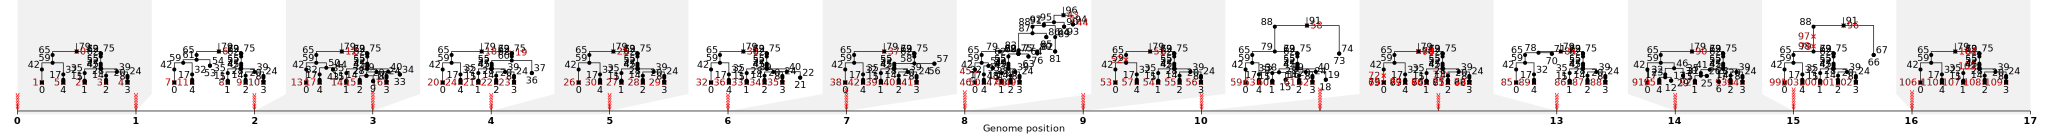

In [9]:
gene_absence_presence_matrix = []

# Add the genes present in the root of the core tree:
for var in mts_core_root.variants():
    if not var.alleles == ('present',): # At least one loss in the leaves
        gene_absence_presence_matrix.append([1 if x == 0 else 0 for x in var.genotypes]) # 0 for absence and 1 for presence have to be swapped.
    else: # No losses in the leaves
        gene_absence_presence_matrix.append(np.ones(num_samples))
gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

print(gene_absence_presence_matrix)


"""
# Iteriere über alle Mutationen und nutze ihren Index als id
for index, mutation in enumerate(mts_core_root.tables.mutations):
    print(
        f"id={index}, site={mutation.site}, node={mutation.node}, "
        f"time={mutation.time}, derived_state={mutation.derived_state}, "
        f"parent={mutation.parent}, metadata={mutation.metadata}"
    )
"""

mts_core_root.draw_svg()

#print(mts_core_root.at(0).draw_text())

[[0 0 1 1 1]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [1 1 0 0 1]
 [1 1 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]
id=0, site=0, node=20, time=0.32345530819555907, derived_state=absent, parent=-1, metadata=b'\x01'
id=1, site=0, node=18, time=0.17200568546853812, derived_state=present, parent=0, metadata=b'\x00'
id=2, site=0, node=0, time=0.039502558504429096, derived_state=absent, parent=0, metadata=b'\x00'
id=3, site=0, node=0, time=1e-11, derived_state=absent, parent=2, metadata=b'\x01'
id=4, site=0, node=1, time=1e-11, derived_state=absent, parent=0, metadata=b'\x01'
id=5, site=0, node=2, time=1e-11, derived_state=present, parent=1, metadata=b'\x01'
id=6, site=0, node=3, time=1e-11, derived_state=present, parent=1, metadata=b'\x01'
id=7, site=0, node=4, time=1e-11, derived_state=present, parent=1, metadata=b'\x03'
id=8, site=1, node=20, time=0.32345530819555907, derived_state=absent, parent=-1, metadata=b'\x01'
id=9, site=1, node=1, time=0.030965516017517673, derived_state=present, parent=8, 

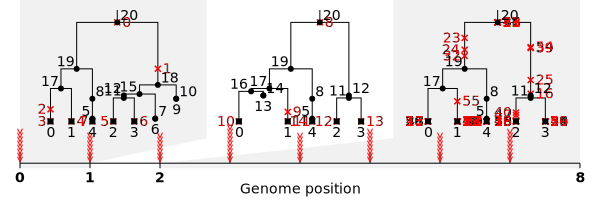

In [57]:
gene_absence_presence_matrix = []

# Add the genes present in the root of the core tree:
for var in mts.variants():
    # if (var.site.position in selected_trees_indexes):
    gene_absence_presence_matrix.append(var.genotypes)
gene_absence_presence_matrix = np.array(gene_absence_presence_matrix)

print(gene_absence_presence_matrix)



# Iteriere über alle Mutationen und nutze ihren Index als id
for index, mutation in enumerate(mts.tables.mutations):
    print(
        f"id={index}, site={mutation.site}, node={mutation.node}, "
        f"time={mutation.time}, derived_state={mutation.derived_state}, "
        f"parent={mutation.parent}, metadata={mutation.metadata}"
    )


mts.draw_svg()



In [32]:
tree_lengths = np.array([mts.at(i).total_branch_length for i in range(0,num_sites)])
tree_lengths_average = sum(tree_lengths)/len(tree_lengths)
tree_lengths_example = sum(np.array([mts.at(i).total_branch_length for i in selected_trees_indexes])) / len(selected_trees_indexes)

print(tree_lengths_average)
print(tree_lengths_example)

1.6679946887178112
1.8668672048279171


In [139]:
number_of_gains = 4
num_sites = 15
tree_lengths = np.array(range(1,num_sites+1))


selected_trees_indexes_array = []
for _ in range(0,100000):
    selected_trees_indexes = []
    k = 0 # This index describes how often a site has gained multiple mutations

    while (len(selected_trees_indexes) < number_of_gains):
    
        if k == 0:
            probabilities = tree_lengths / sum(tree_lengths)
        else: 
            probabilities = np.ones(num_sites)
            for i in range(0,k+1):
                probabilities = probabilities - math.comb(number_of_gains, i) * (1-tree_lengths / sum(tree_lengths)) ** (number_of_gains-i) * (tree_lengths / sum(tree_lengths)) ** i
            probabilities[selected_trees_indexes] = 0
            probabilities = probabilities / sum(probabilities)
    
        selected_trees = np.random.choice(np.array(range(0,num_sites)), size=number_of_gains - len(selected_trees_indexes), replace=True, p=probabilities)
        selected_trees_indexes.extend(np.unique(selected_trees))
        k = k + 1
    selected_trees_indexes_array.extend(selected_trees_indexes)

from collections import Counter
counts = Counter(selected_trees_indexes_array)
print(counts)
print("Average:", sum(tree_lengths)/len(tree_lengths))
print("Averange 2:", sum(tree_lengths[selected_trees_indexes_array])/len(selected_trees_indexes_array))

Counter({14: 48598, 13: 45357, 12: 42701, 11: 39651, 10: 36994, 9: 33675, 8: 30359, 7: 26948, 6: 24032, 5: 20457, 4: 17283, 3: 13583, 2: 10014, 1: 6937, 0: 3411})
Average: 8.0
Averange 2: 10.26608


In [138]:
838*np.array(range(1,num_sites+1))

array([  838,  1676,  2514,  3352,  4190,  5028,  5866,  6704,  7542,
        8380,  9218, 10056, 10894, 11732, 12570])